**<font color = 'green'>**Desafío - Detección temprana de renuncias en
empresa de telecomunicaciones**</font>**

Objetivo: entrenar un modelo de ensamble que permita predecir
tempranamente si un cliente renunciará a la compañía

# Importamos las librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.preprocessing import StandardScaler

#Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#Balanceo
from imblearn.over_sampling import SMOTE

#Evaluacion
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve

#CV e hiperparametros
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

from scipy.stats import mode

#Montamos el drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Cargamos el dataset
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Redes neuronales/1.Modelos de ensamble Parte I/Desafio/telecom_churn.csv")

#Llevamos todos nombres de columnas a minusculas
old_cols = df.columns.to_list()
cols_low = [col.lower() for col in old_cols]
df = df.rename(columns=dict(zip(old_cols,cols_low)))

# 1.Importa las librerías necesarias y la base de datos, y realiza un análisis por variable usando visualizaciones. Debes considerar las posibles correlaciones y representarlas en un heatmap.

In [ ]:
def data_quality (df,df_name):
  #Dimension
  print("======= Revision de dimension ==========")
  print("")
  print(f"El shape de {df_name} es {df.shape}")
  print("")
  #Revision de valores nulls
  print("======= Revision de nulos ==========")
  print("")
  print(f"Cantidad de nulos por columna en el dataset {df_name}:")
  print("")
  for colname in df.columns:
    col_nulls= df[colname].isna().sum()
    print(f"{colname}: {col_nulls}")
  print("")

  #Revision dtypes
  print("")
  print("======= Revision dtypes ==========")
  print("")
  print(df.dtypes)

  #Revision de duplicados
  print("")
  print("======= Revision duplicados ==========")
  print("")
  print(f"Cantidad de duplicados en {df_name} : {df.duplicated().sum()}")

  #Revision de valores unicos, con esto podemos ver si las variables categoricas presentan valores erroneos, ya que los outliers solo aplican para numericas.
  print("")
  print("======= Revision valores unicos ==========")
  print("")
  for colname in df.columns:
    col_nunique= df[colname].nunique()
    print(f"{colname}: {col_nunique}")
  print("")

  #Valores unicos variables categoricas
  print("")
  print("======= Revision valores unicos categoricas ==========")
  print("")
  for colname in df.columns:
    if df[colname].dtypes not in ["int","float"]:
      col_unique= df[colname].unique()
      print(f"Columna {colname}:")
      print("")
      print(col_unique)
      print("")

In [ ]:
data_quality(df,"Dataset Telecomunicaciones")

======= Revision de dimension ==========

El shape de Dataset Telecomunicaciones es (3333, 11)

======= Revision de nulos ==========

Cantidad de nulos por columna en el dataset Dataset Telecomunicaciones:

churn: 0
accountweeks: 0
contractrenewal: 0
dataplan: 0
datausage: 0
custservcalls: 0
daymins: 0
daycalls: 0
monthlycharge: 0
overagefee: 0
roammins: 0


======= Revision dtypes ==========

churn                int64
accountweeks         int64
contractrenewal      int64
dataplan             int64
datausage          float64
custservcalls        int64
daymins            float64
daycalls             int64
monthlycharge      float64
overagefee         float64
roammins           float64
dtype: object

======= Revision duplicados ==========

Cantidad de duplicados en Dataset Telecomunicaciones : 0

======= Revision valores unicos ==========

churn: 2
accountweeks: 212
contractrenewal: 2
dataplan: 2
datausage: 174
custservcalls: 10
daymins: 1667
daycalls: 119
monthlycharge: 627
overagefee:

La revision de calidad de datos muestra la no existencia de nulos y valores duplicados. Tambien nos indica que todas las variables son numericas, sin embargo algunas realmente representan condiciones booleanas

**Analisis exploratorio de datos**

In [ ]:
#Transformamos las numericas que son booleanas para poder separar la visualizacion
to_bool = ["churn","contractrenewal","dataplan"]
for col in to_bool:
  df[col] = df[col].astype(bool)

**Analisis univariado**

In [ ]:
def get_uni(df):
  plt.figure(figsize = (30,30))
  for n,col in enumerate(df.columns):
    plt.subplot(6,4, n+1)
    if df[col].dtype in ['O',bool]:
      sns.countplot(y = df[col],color="grey",alpha=0.3)
      plt.title(f'Frecuencias de {col}')
    else:
      sns.histplot(df[col],kde=True,alpha=0.2,lw=0.5)
      plt.axvline(df[col].mean(), color = 'tomato', ls = '--',label=f"Mean {round(df[col].mean(),2)}")
      plt.legend()
      plt.title(f'Distribución de {col}')
  plt.tight_layout()

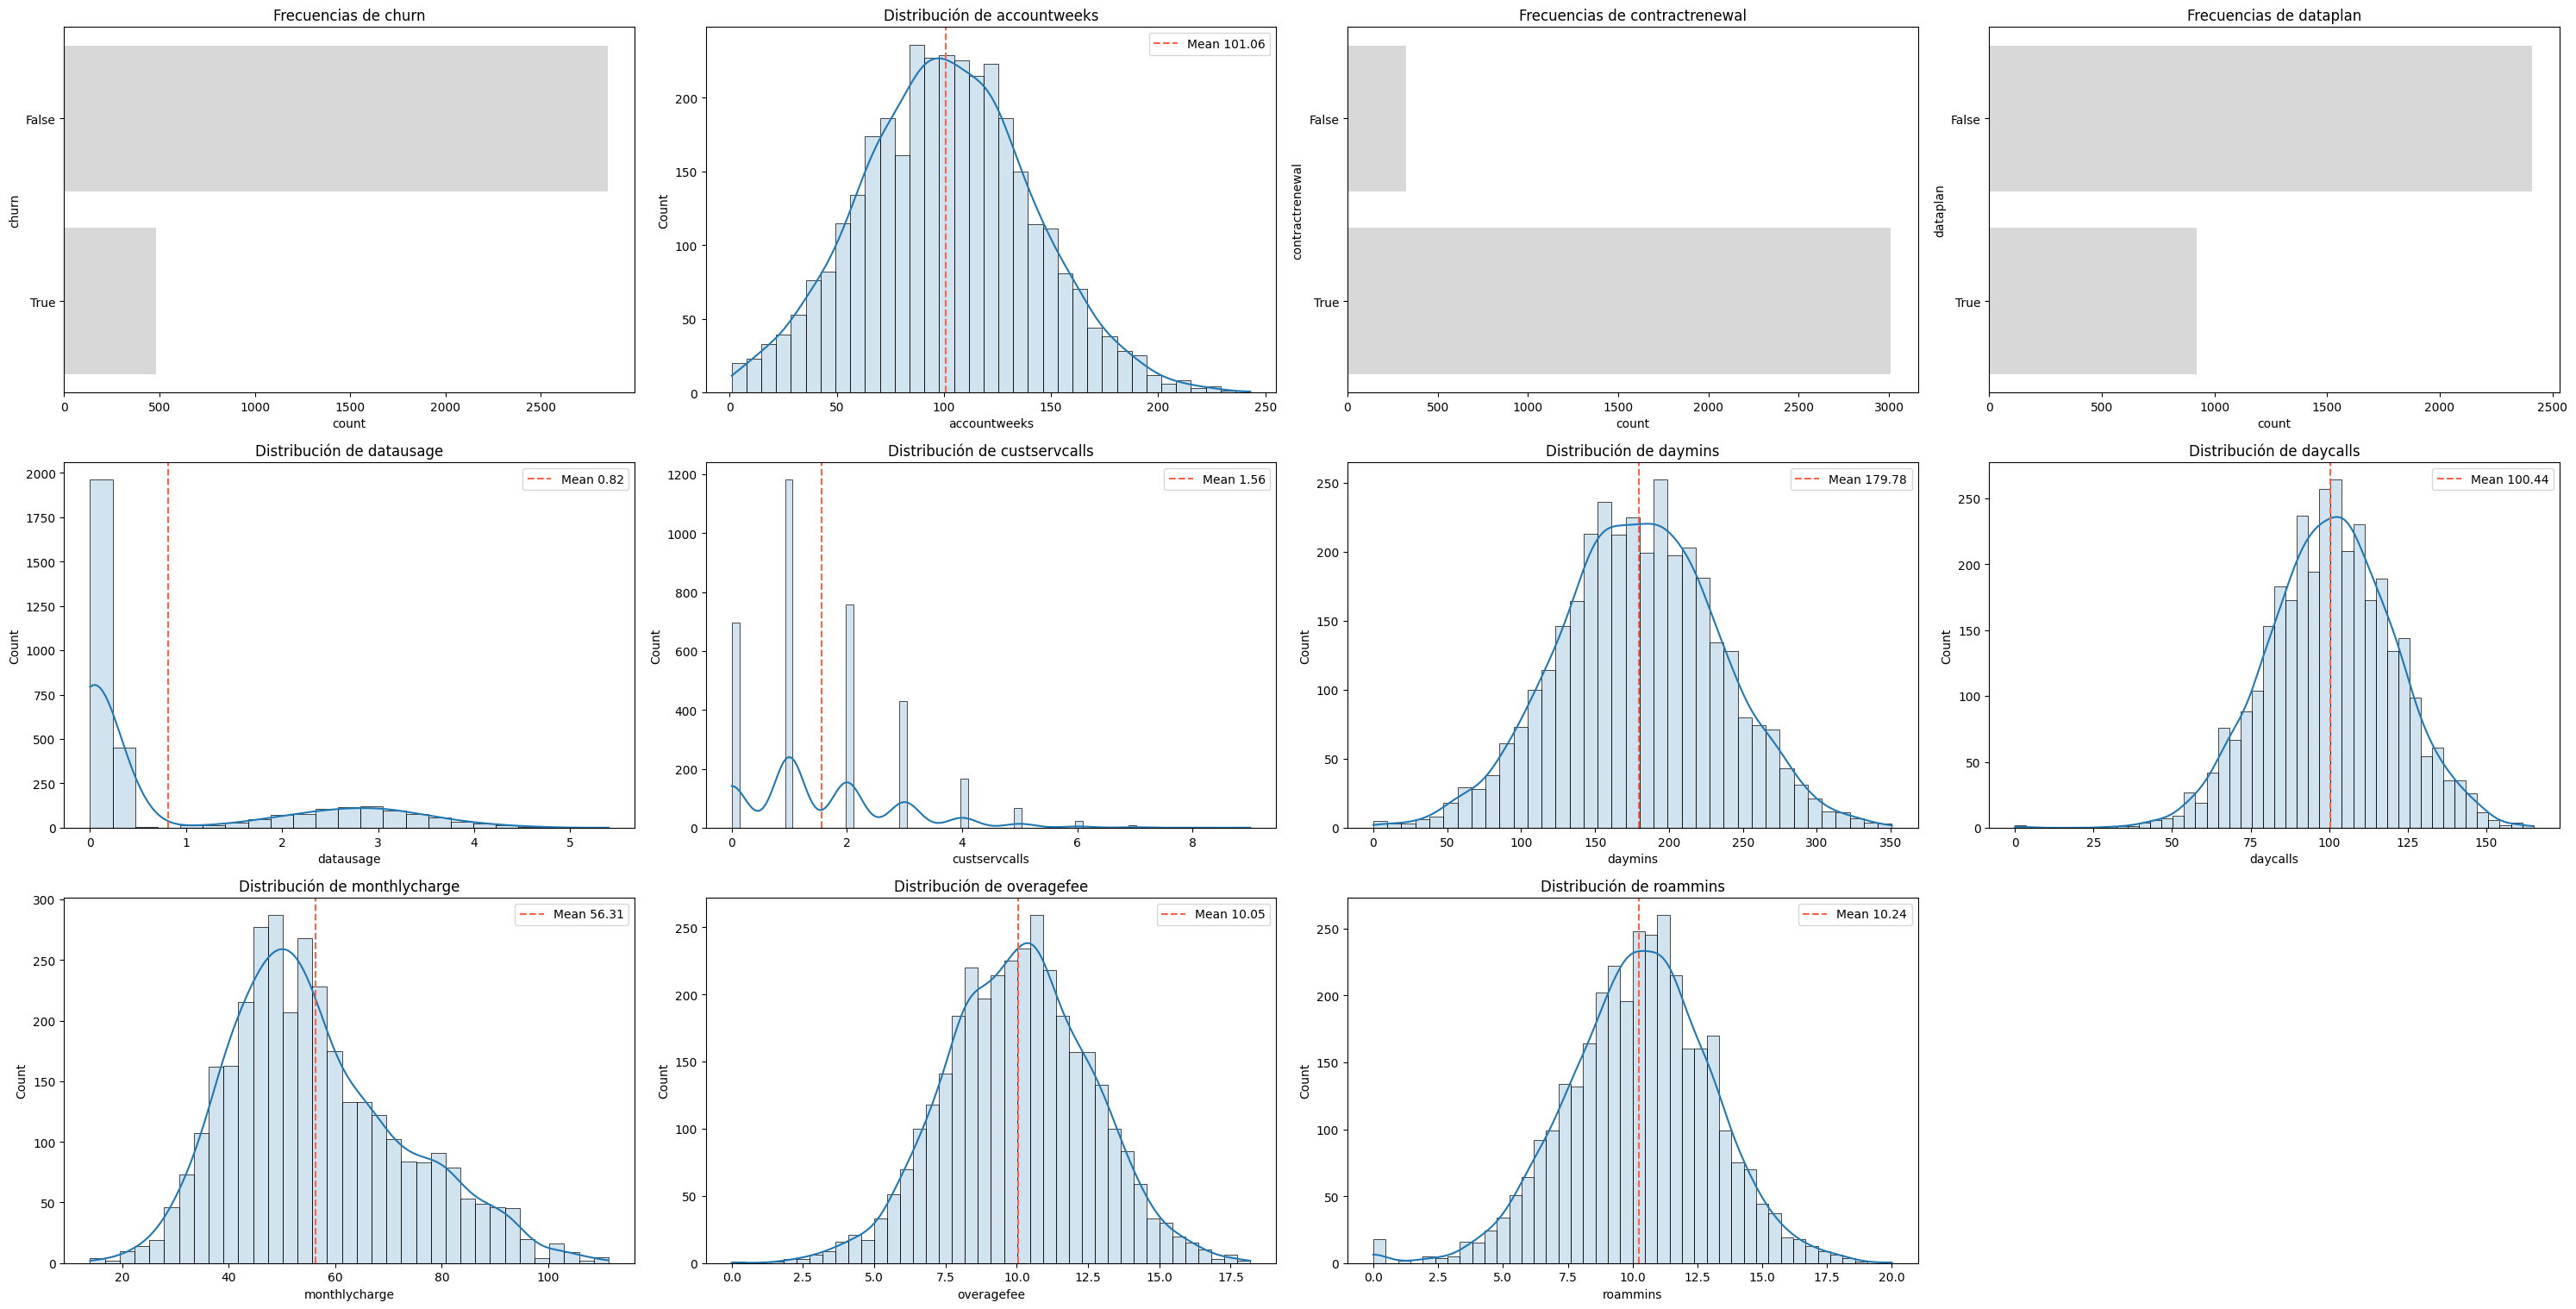

In [ ]:
get_uni(df)

In [ ]:
to_percent = ["churn","contractrenewal","dataplan"]
for col in to_percent:
  print(df[col].value_counts("%"))
  print()

churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64

contractrenewal
True     0.90309
False    0.09691
Name: proportion, dtype: float64

dataplan
False    0.723372
True     0.276628
Name: proportion, dtype: float64



**Conclusiones analisis univariado:**

**Variables booleanas:**

1.   Desbalance de clases de 86-14% aprox con respecto a la clase minoritaria (churn 1), se tendran que balancear para modelar.
2.   Un 90% de los clientes ha renovado su servicio
3.   Un 27% de los clientes tiene plan de datos.

**Variables Numericas:**
*   El promedio de tiempo activo de las cuentas ronda las 100 semanas
*   La tendencia en el uso de datos se presenta en rangos menores a 1 GB.
*   Generalmente los clientes tienen entre 0 y 2 llamadas al servicio al cliente
*   Las distribuciones de Daymins y DayCalls presentan una distribucion normal, con valores promedio de 180 y 100 respectivamente.
*   La factura mensual en promedio ronda por 56 (moneda no declarada)
*   Promedio de mayor cuota de exceso es 10
*   Minutos de roaming promedio es 10 minutos

**En general las variables numericas presentan una distribucion normal, y no se aprecian sesgos o outliers a primera vista que pudieran ser limpiados con IQR.**



**Analisis de correlaciones**

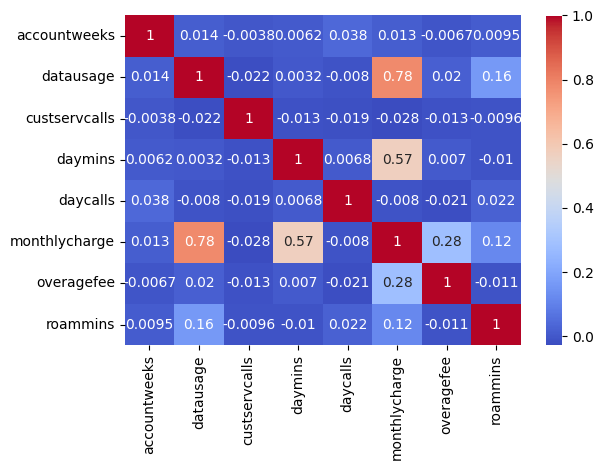

In [ ]:
numeric_cols = df.select_dtypes(include=["int","float"])
df_corr = numeric_cols.corr()
sns.heatmap(df_corr,annot=True,cmap="coolwarm")
plt.tight_layout()

**El analis de las correlaciones de Pearson entre las variables numericas, revelan que no existen tantas correlaciones fuertes, y las existentes, no son lo suficientemente altas entre si como para producir problemas de multicolinealidad. Se destacan bueas correlaciones entre mothlycharge co datausage y dailymins co mothlycarge, ya que por razones logicas, mientras más data y minutos se usan, más sube la cuenta mensualmente, al igual que con overagefee, pero esta última no presenta una correlacion tan alta. Importante indicar que este analisis de correlaciones no define cual es la explicabilidad de cada variable contra el target, ya que este ultimo es categorico.**

# 2.Desarrolla un modelo de árbol de decisión sin modificar sus hiper parámetros y despliega sus métricas de desempeño. Luego, mejora este modelo de forma de evitar el overfitting usando búsqueda por grilla con 5 kfold:

*   max_depth: [5, 10, 15, 20, 25]
*   min_samples_split: [0.01, 0.02, 0.03, 0.04]


In [ ]:
#Instanciamos SMOTE
oversampler = SMOTE(random_state=16)

#Definimos target y predictores
X = df.drop(columns="churn")
y= df["churn"]

#Balanceamos
X, y = oversampler.fit_resample(X,y)

#Hacemos el split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=16)

In [ ]:
#Primero modelamos el arbol sin hiperparametros
base_tree = DecisionTreeClassifier()

In [ ]:
def predict_metrics(model): #Definimos una funcion para optimizar codigo adelante
  #Ajustamos
  model.fit(X_train,y_train)

  #Realizamos predicciones en train y test
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  print("===============================================================")
  # Calcular la matriz de confusión TRAIN
  conf_matrix_train = confusion_matrix(y_train, y_pred_train)
  print("Matriz de Confusión: TRAIN")
  print()
  print(conf_matrix_train)
  print()
  # Imprimir el informe de clasificación TRAIN
  report_train = classification_report(y_train, y_pred_train)
  print("Informe de Clasificación: TRAIN")
  print(report_train)

  # Calcular AUC-ROC / AUC-PR TRAIN
  roc_train = roc_auc_score(y_train, y_pred_train)
  pr_train = average_precision_score(y_train, y_pred_train)

  print(f"AUC-ROC para TRAIN : {round(roc_train,3)}")
  print(f"AUC-PR para TRAIN : {round(pr_train,3)}")


  print("===============================================================")


  # Calcular la matriz de confusión TEST
  conf_matrix_test = confusion_matrix(y_test, y_pred_test)
  print("Matriz de Confusión: TEST")
  print()
  print(conf_matrix_test)
  print()
  # Imprimir el informe de clasificación TEST
  report_test = classification_report(y_test, y_pred_test)
  print("Informe de Clasificación: TEST")
  print(report_test)

  # Calcular AUC-ROC / AUC-PR TEST
  roc_test = roc_auc_score(y_test, y_pred_test)
  pr_test = average_precision_score(y_test, y_pred_test)

  print(f"AUC-ROC para TEST : {round(roc_test,3)}")
  print(f"AUC-PR para TEST : {round(pr_test,3)}")

In [ ]:
predict_metrics(base_tree)

Matriz de Confusión: TRAIN

[[2261    0]
 [   0 2299]]

Informe de Clasificación: TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2261
        True       1.00      1.00      1.00      2299

    accuracy                           1.00      4560
   macro avg       1.00      1.00      1.00      4560
weighted avg       1.00      1.00      1.00      4560

AUC-ROC para TRAIN : 1.0
AUC-PR para TRAIN : 1.0
Matriz de Confusión: TEST

[[472 117]
 [ 66 485]]

Informe de Clasificación: TEST
              precision    recall  f1-score   support

       False       0.88      0.80      0.84       589
        True       0.81      0.88      0.84       551

    accuracy                           0.84      1140
   macro avg       0.84      0.84      0.84      1140
weighted avg       0.84      0.84      0.84      1140

AUC-ROC para TEST : 0.841
AUC-PR para TEST : 0.767


**Busqueda de hiperparametros con GridSearch para mejorar el overfitting del base model**

In [ ]:
#Definimos los hiperparametros a testear
params = {"max_depth": [5, 10, 15, 20, 25],
          "min_samples_split": [0.01, 0.02, 0.03, 0.04]}

#Realizamos la grilla
grid_search = GridSearchCV(base_tree,params,n_jobs=-1,cv=5,scoring="f1") #5 kfolds

#Ajustamos la grilla
grid_search.fit(X_train,y_train)

#Obtenemos los mejores hiperparametros
best_params = grid_search.best_params_

print(f"Mejores hiperparametros: {best_params}")


# Imprime la precisión del modelo en el conjunto de prueba
print("f1 en train:", grid_search.score(X_train, y_train))
print("f1 en test:", grid_search.score(X_test, y_test))

Mejores hiperparametros: {'max_depth': 20, 'min_samples_split': 0.01}
f1 en train: 0.868802106186924
f1 en test: 0.8044077134986226


In [ ]:
tree_opt = DecisionTreeClassifier(**best_params,random_state=16)

In [ ]:
predict_metrics(tree_opt)

Matriz de Confusión: TRAIN

[[1982  279]
 [ 319 1980]]

Informe de Clasificación: TRAIN
              precision    recall  f1-score   support

       False       0.86      0.88      0.87      2261
        True       0.88      0.86      0.87      2299

    accuracy                           0.87      4560
   macro avg       0.87      0.87      0.87      4560
weighted avg       0.87      0.87      0.87      4560

AUC-ROC para TRAIN : 0.869
AUC-PR para TRAIN : 0.825
Matriz de Confusión: TEST

[[489 100]
 [113 438]]

Informe de Clasificación: TEST
              precision    recall  f1-score   support

       False       0.81      0.83      0.82       589
        True       0.81      0.79      0.80       551

    accuracy                           0.81      1140
   macro avg       0.81      0.81      0.81      1140
weighted avg       0.81      0.81      0.81      1140

AUC-ROC para TEST : 0.813
AUC-PR para TEST : 0.746


Conclusiones: La busqueda de hiperparametros logró reducir el overfitting de manera correcta, sin disminuir tanto el rendimiento en test.

# 3.Balancea las clases usando SMOTE para el conjunto de entrenamiento. Luego, aplica un modelo de Bagging con 200 estimadores y muestra las métricas sobre el conjunto de test.

Nota: Las clases ya se balancearon con smote anteriormente para obtener metricas precisas a la hora de clasificar el target.

In [ ]:
#Instanciamos el modelo bagging
bagg_base = BaggingClassifier(n_estimators=200,n_jobs=-1,random_state=16,oob_score=True)

In [ ]:
#Obtenemos las metricas
predict_metrics(bagg_base)

In [ ]:
def get_oob(model):
  #Printeamos el score del OOB
  print("OOB score:", model.oob_score_)

In [ ]:
get_oob(bagg_base)

OOB score: 0.8945175438596491


**Conclusiones modelo base Bagging con 200 algoritmos:**
* Las métricas en test mejoran considerablemente, un 6% mejor que el arbol optimizado, sin embargo el modelo presenta overfitting.

# 4.Implementa un modelo de Bagging usando modelos heterogéneos con los siguientes estimadores: Regresión Logística, Árbol de decisión, y dos SVM de clasificación con kernel ‘rbf’ y ‘sigmoid’. Para ello considera 200 muestras bootstrap (T).

In [ ]:
#Creamos el modelo apoyandonos en la funcion entregada en util bagging
from util_bagging import *

In [ ]:
#Instanciamos los modelos heterogeneos
logistic_regression = LogisticRegression(random_state=16,n_jobs=-1)
decision_tree = DecisionTreeClassifier(random_state=16)
svm_rbf = SVC(kernel="rbf",random_state=16)
svm_sigmoid = SVC(kernel="sigmoid",random_state=16)

#Creamos la lista de los estimadores
estimators = [logistic_regression, decision_tree, svm_rbf, svm_sigmoid]

In [ ]:
#Ejecutamos la funcion
trained_models, y_pred_test, y_pred_out, _ = bagging_het(X_train,y_train,200,estimators,X_test) #y_pred_Test predic individuales, y_pred_out predict con la votacion mayoritaria

Evaluamos el modelo

In [ ]:
print("Matriz de confusion")
print(confusion_matrix(y_test,y_pred_out))
print()

print("Reporte de clasificacion")
print(classification_report(y_test,y_pred_out))
print()

# Calcular AUC-ROC / AUC-PR TEST
roc_test = roc_auc_score(y_test, y_pred_out)
pr_test = average_precision_score(y_test, y_pred_out)

print(f"AUC-ROC para TRAIN : {round(roc_test,3)}")
print(f"AUC-PR para TRAIN : {round(pr_test,3)}")

Matriz de confusion
[[506  83]
 [149 402]]

Reporte de clasificacion
              precision    recall  f1-score   support

       False       0.77      0.86      0.81       589
        True       0.83      0.73      0.78       551

    accuracy                           0.80      1140
   macro avg       0.80      0.79      0.79      1140
weighted avg       0.80      0.80      0.80      1140


AUC-ROC para TRAIN : 0.794
AUC-PR para TRAIN : 0.735


# 5.Implementa un modelo de ensamble Random Forest usando como hiper parámetro n_estimators = 45. El modelo debe usar muestra OOB para estimar su ajuste ACCURACY, y debe mostrar las cuatro características más importantes junto con las métricas de desempeño en el conjunto de test.

In [ ]:
#Instanciamos el modelo
base_rf = RandomForestClassifier(n_estimators=45,bootstrap=True,oob_score=True,n_jobs=-1,random_state=16).fit(X_train,y_train)

In [ ]:
get_oob(base_rf)

OOB score: 0.9046052631578947


In [ ]:
def get_importances(df,model):# Feature importances
  importances = model.feature_importances_
  columns = X_train.columns
  indices = np.argsort(importances)[::-1]
  top_4 = indices[:4]

  plt.figure(figsize=(8, 6))
  bar_plot = sns.barplot(x=columns[top_4], y=importances[top_4],alpha=0.5)
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha="right")
  plt.tight_layout()
  plt.show()

<ipython-input-25-7f82efb84899>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha="right")


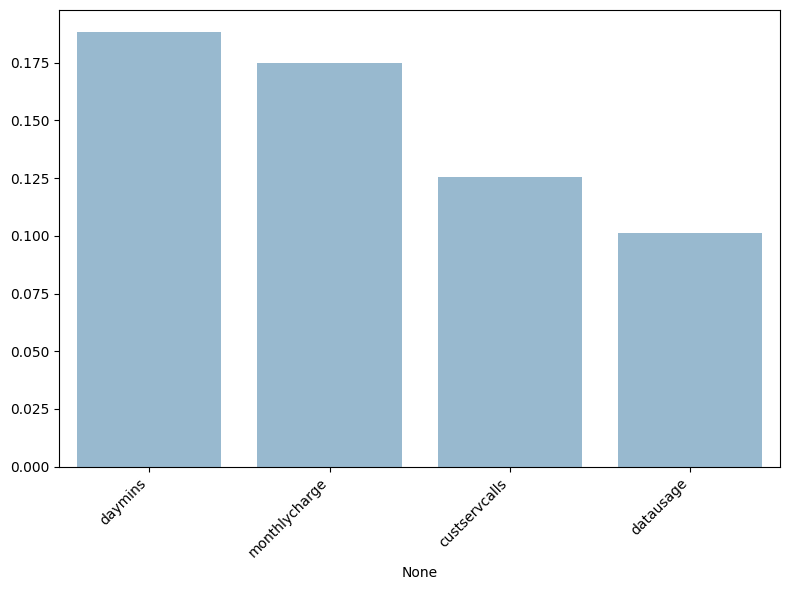

In [ ]:
get_importances(df,base_rf)

In [ ]:
predict_metrics(base_rf)

Matriz de Confusión: TRAIN

[[2261    0]
 [   0 2299]]

Informe de Clasificación: TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2261
        True       1.00      1.00      1.00      2299

    accuracy                           1.00      4560
   macro avg       1.00      1.00      1.00      4560
weighted avg       1.00      1.00      1.00      4560

AUC-ROC para TRAIN : 1.0
AUC-PR para TRAIN : 1.0
Matriz de Confusión: TEST

[[551  38]
 [ 54 497]]

Informe de Clasificación: TEST
              precision    recall  f1-score   support

       False       0.91      0.94      0.92       589
        True       0.93      0.90      0.92       551

    accuracy                           0.92      1140
   macro avg       0.92      0.92      0.92      1140
weighted avg       0.92      0.92      0.92      1140

AUC-ROC para TEST : 0.919
AUC-PR para TEST : 0.885


**Conclusiones rf base:**
* El modelo cuenta con buen rendimiento en test, y un buen f1-score del target 1 de un 92%, sin embargo cuenta con overfitting, el cual resolveremos con la busqueda de hiperparametros.

# 6.Realiza una búsqueda de grilla para un modelo Random Forest para los siguientes rangos de valores para sus hiper parámetros:

n_estimators: 50 - 200 con paso de 10 completando 15 valores
max_features: [‘sqrt’, ‘log2’, None]

In [ ]:
#Creamos los hiperparametros a testear
rf_params = {"n_estimators": np.arange(50,200,10), #Parametros solicitados
             "max_features": ["sqrt", "log2", None], #Parametros solicitados
             "min_samples_split": [0.1,0.2,0.3], #Esto se agrego para reducir el sobreajuste
             "max_depth": [10,20,30] #Esto se agrego para reducir el sobreajuste
             }

In [ ]:
#Instanciamos el rf
rf = RandomForestClassifier(random_state=16)

#Instanciamos la grilla
grid_search = GridSearchCV(rf,rf_params,cv=5,scoring="f1",verbose=1,n_jobs=-1)

#Ajustamos
grid_search.fit(X_train,y_train)

#Obtenemos los mejores hiper
best_params = grid_search.best_params_

print(f"Mejores hiperparametros: {best_params}")

# f1 del modelo en el conjunto de prueba
print("f1 en train:", grid_search.score(X_train, y_train))
print("f1 en test:", grid_search.score(X_test, y_test))

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Mejores hiperparametros: {'max_depth': 10, 'max_features': None, 'min_samples_split': 0.1, 'n_estimators': 50}
f1 en train: 0.7580174927113702
f1 en test: 0.7564870259481037


In [ ]:
#Entrenamos el rf optimizado
rf_opt = RandomForestClassifier(**best_params,n_jobs=-1,bootstrap=True,oob_score=True)
#Ajustamos
rf_opt.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, max_features=None, min_samples_split=0.1,
                       n_estimators=50, n_jobs=-1, oob_score=True)

Mostramos su desempeño y las features importances

In [ ]:
get_oob(rf_opt)

OOB score: 0.7793859649122807


In [ ]:
predict_metrics(rf_opt)

Matriz de Confusión: TRAIN

[[1985  276]
 [ 709 1590]]

Informe de Clasificación: TRAIN
              precision    recall  f1-score   support

       False       0.74      0.88      0.80      2261
        True       0.85      0.69      0.76      2299

    accuracy                           0.78      4560
   macro avg       0.79      0.78      0.78      4560
weighted avg       0.79      0.78      0.78      4560

AUC-ROC para TRAIN : 0.785
AUC-PR para TRAIN : 0.745
Matriz de Confusión: TEST

[[511  78]
 [169 382]]

Informe de Clasificación: TEST
              precision    recall  f1-score   support

       False       0.75      0.87      0.81       589
        True       0.83      0.69      0.76       551

    accuracy                           0.78      1140
   macro avg       0.79      0.78      0.78      1140
weighted avg       0.79      0.78      0.78      1140

AUC-ROC para TEST : 0.78
AUC-PR para TEST : 0.724


<ipython-input-25-7f82efb84899>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha="right")


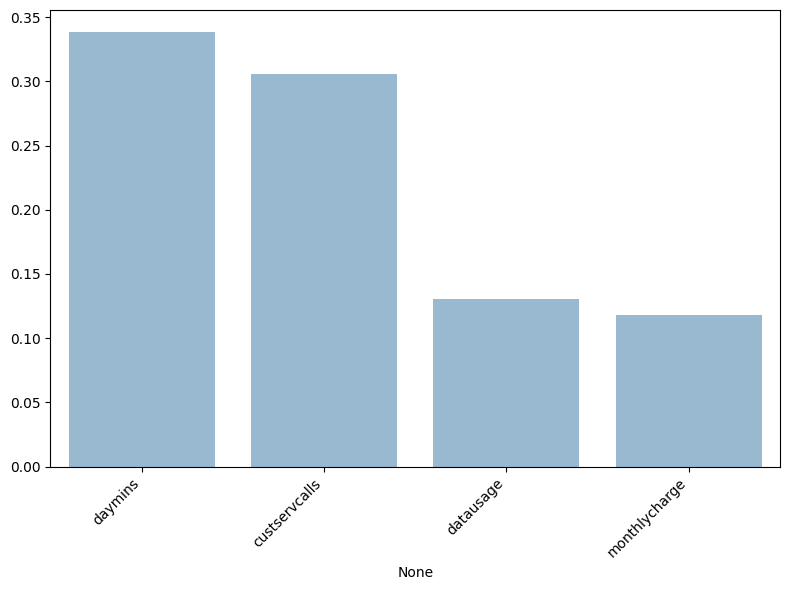

In [ ]:
get_importances(df,rf_opt)

**Conclusiones Random Forest Optimizado:**
*  Como era de esperar, con la busqueda de hiperparametros logramos reducir el overfitting del modelo, lo cual como consecuencia disminuyó el rendimiento de este, sin embargo ahora es posible utilizarlo para hacer predicciones. Con un 76% de f1 score de la clase a predecir (churn true), es un modelo aceptable y que podrá ser usado en el siguiente punto.


*  Importante indicar que utilizando la busqueda de solo los hiperparametros que pedian en el desafio, el modelo sigue teniendo overfitting, ya que no se esta controlando la poda del arbol en cuanto a su profundidad, lo cual potenciaba el sobreajuste.

# 7.Usando el modelo Random Forest con sus hiper parámetros ajustados, muestre los 15 clientes que presentan la mayor propensión a renunciar.

In [ ]:
#Calculamos la proba
probabilidad_renuncia = rf_opt.predict_proba(X_test)[:,1] #Con 1 es la probabilidad del target 1 (renuncia)
X_test_churn = X_test.copy() #Hacemos una copia de test para poder incorporarle la columna de la proba
X_test_churn["churn_proba"] = probabilidad_renuncia

#Creamos el top15
top15_churn = X_test_churn.sort_values(by="churn_proba",ascending=False).head(15)
top15_churn

,accountweeks,contractrenewal,dataplan,datausage,custservcalls,daymins,daycalls,monthlycharge,overagefee,roammins,churn_proba
3482,93,True,False,0.128394,1,271.146503,102,66.888864,11.060856,9.841578,0.988833
4430,83,True,False,0.046893,1,291.600944,102,69.799031,11.100492,12.476701,0.988833
3473,114,True,False,0.118156,0,293.062197,99,70.743948,11.380559,11.188083,0.988833
3711,71,True,False,0.004663,2,290.512192,108,71.002914,12.661680,10.094172,0.988833
5012,110,True,False,0.028242,2,270.585592,106,66.979827,11.737032,10.243803,0.988833
3894,131,True,False,0.000000,0,295.689034,94,70.000000,11.373555,11.729896,0.988833
3611,103,True,False,0.000000,1,273.433422,119,69.506950,13.106956,10.937326,0.988833
3873,74,True,False,0.000000,1,309.830066,95,70.627814,10.303968,10.497139,0.988833
5203,60,True,False,0.000000,2,287.553904,101,70.809653,12.882787,11.966486,0.988833
5231,73,True,False,0.148709,0,281.449304,112,67.611514,10.565129,10.071278,0.988833
